In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
latt_size = (16, 16, 8, 8)
# latt_size = (8, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-6

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1672823749344572e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)
mg.init()

self.dof_list:[12, 24, 24, 24, 24]
Building grid list:
  Level 0: 16x16x8x8
  Level 1: 8x8x4x4
  Level 2: 4x4x2x2
self.grid_list:[[8, 8, 16, 16], [4, 4, 8, 8], [2, 2, 4, 4]]
Norm of b:496.8489190829809
Norm of r:702.0913388519872
Norm of x0:442.665398691082
BICGSTAB-Iteration 0: Residual = 1.209109e+02, Time = 0.013037 s
BICGSTAB-Iteration 1: Residual = 3.965653e+01, Time = 0.012100 s
BICGSTAB-Iteration 2: Residual = 6.257557e+01, Time = 0.011969 s
BICGSTAB-Iteration 3: Residual = 1.322394e+01, Time = 0.011966 s
BICGSTAB-Iteration 4: Residual = 9.145184e+00, Time = 0.011934 s
BICGSTAB-Iteration 5: Residual = 5.587011e+00, Time = 0.011938 s
BICGSTAB-Iteration 6: Residual = 4.698281e+00, Time = 0.011934 s
BICGSTAB-Iteration 7: Residual = 6.961979e+00, Time = 0.011951 s
BICGSTAB-Iteration 8: Residual = 3.633840e+00, Time = 0.011933 s
BICGSTAB-Iteration 9: Residual = 2.961545e+00, Time = 0.011940 s
BICGSTAB-Iteration 10: Residual = 2.157910e+00, Time = 0.011943 s
BICGSTAB-Iteration 11: Res

BICGSTAB-Iteration 30: Residual = 2.869809e-01, Time = 0.011942 s
BICGSTAB-Iteration 31: Residual = 1.595096e-01, Time = 0.012146 s
BICGSTAB-Iteration 32: Residual = 1.116905e-01, Time = 0.012116 s
BICGSTAB-Iteration 33: Residual = 1.150484e-01, Time = 0.011960 s
BICGSTAB-Iteration 34: Residual = 9.931123e-02, Time = 0.011958 s
BICGSTAB-Iteration 35: Residual = 9.351934e-02, Time = 0.011953 s
BICGSTAB-Iteration 36: Residual = 8.241302e-02, Time = 0.011949 s
BICGSTAB-Iteration 37: Residual = 8.683820e-02, Time = 0.011967 s
BICGSTAB-Iteration 38: Residual = 9.478290e-02, Time = 0.011972 s
BICGSTAB-Iteration 39: Residual = 1.234140e-01, Time = 0.012089 s
BICGSTAB-Iteration 40: Residual = 2.497312e-01, Time = 0.012818 s
BICGSTAB-Iteration 41: Residual = 8.750397e+00, Time = 0.011967 s
BICGSTAB-Iteration 42: Residual = 3.048541e-01, Time = 0.011944 s
BICGSTAB-Iteration 43: Residual = 9.690043e-02, Time = 0.012082 s
BICGSTAB-Iteration 44: Residual = 1.011328e-01, Time = 0.011934 s
BICGSTAB-I

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 2.83 ms, sys: 152 μs, total: 2.99 ms
Wall time: 2.81 ms
CPU times: user 1.28 ms, sys: 68 μs, total: 1.35 ms
Wall time: 1.34 ms
443.40500673763256
0.0
497.0232896989116
497.0232896989116
1.394175096325101e-16
CPU times: user 58.4 ms, sys: 247 μs, total: 58.6 ms
Wall time: 57.9 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 3.48 ms, sys: 78 μs, total: 3.56 ms
Wall time: 3.12 ms
CPU times: user 0 ns, sys: 1.28 ms, total: 1.28 ms
Wall time: 1.24 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+1.2939e-16j, 1.0000+2.2714e-16j, 1.0000-3.1399e-16j,
        1.0000-7.7042e-17j, 1.0000-1.1070e-16j, 1.0000+6.7196e-16j,
        1.0000-1.2328e-16j, 1.0000-3.5371e-18j, 1.0000+6.4565e-16j,
        1.0000-4.1410e-17j, 1.0000+1.3876e-17j, 1.0000+6.5091e-16j,
        1.0000-6.9119e-18j, 1.0000-1.2675e-16j, 1.0000-1.2746e-16j,
        1.0000-2.1420e-17j, 1.0000-3.6199e-17j, 1.0000+2.0025e-17j,
        1.0000-3.7059e-16j, 1.0000-2.4636e-16j, 1.0000+1.4831e-16j,
        1.0000-5.3918e-16j, 1.0000+1.3745e-16j, 1.0000-7.8988e-16j,
        1.0000-4.1280e-16j, 1.0000-5.8443e-18j, 1.0000+3.0439e-17j,
        1.0000-5.1594e-16j, 1.0000-1.0492e-16j, 1.0000-2.8424e-16j,
        

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, tol=tol, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, tol=tol, verbose=verbose)

Norm of b:442.82798787465305
Norm of r:664.9245558884963
Norm of x0:443.52176180130994
BICGSTAB-Iteration 0: Residual = 1.432518e+02, Time = 0.012018 s
BICGSTAB-Iteration 1: Residual = 6.002547e+01, Time = 0.012088 s
BICGSTAB-Iteration 2: Residual = 6.789970e+01, Time = 0.011934 s
BICGSTAB-Iteration 3: Residual = 3.921679e+01, Time = 0.011932 s
BICGSTAB-Iteration 4: Residual = 2.437815e+01, Time = 0.012051 s
BICGSTAB-Iteration 5: Residual = 2.294027e+01, Time = 0.012287 s
BICGSTAB-Iteration 6: Residual = 1.500216e+01, Time = 0.012080 s
BICGSTAB-Iteration 7: Residual = 1.260344e+01, Time = 0.011980 s
BICGSTAB-Iteration 8: Residual = 1.148100e+01, Time = 0.011940 s
BICGSTAB-Iteration 9: Residual = 7.121310e+00, Time = 0.011955 s
BICGSTAB-Iteration 10: Residual = 6.244759e+00, Time = 0.011956 s
BICGSTAB-Iteration 11: Residual = 5.942115e+00, Time = 0.012076 s
BICGSTAB-Iteration 12: Residual = 5.147139e+00, Time = 0.011980 s
BICGSTAB-Iteration 13: Residual = 5.261329e+00, Time = 0.012033 s

BICGSTAB-Iteration 38: Residual = 1.160012e+00, Time = 0.012351 s
BICGSTAB-Iteration 39: Residual = 9.698672e-01, Time = 0.012376 s
BICGSTAB-Iteration 40: Residual = 3.801427e+00, Time = 0.012245 s
BICGSTAB-Iteration 41: Residual = 2.892340e+00, Time = 0.012232 s
BICGSTAB-Iteration 42: Residual = 4.851826e+00, Time = 0.012247 s
BICGSTAB-Iteration 43: Residual = 5.193828e+00, Time = 0.012041 s
BICGSTAB-Iteration 44: Residual = 6.329665e+00, Time = 0.012067 s
BICGSTAB-Iteration 45: Residual = 1.485614e+00, Time = 0.012486 s
BICGSTAB-Iteration 46: Residual = 8.682122e-01, Time = 0.012192 s
BICGSTAB-Iteration 47: Residual = 6.033731e-01, Time = 0.012165 s
BICGSTAB-Iteration 48: Residual = 5.106364e-01, Time = 0.012161 s
BICGSTAB-Iteration 49: Residual = 3.970919e-01, Time = 0.012194 s
BICGSTAB-Iteration 50: Residual = 4.574457e-01, Time = 0.012200 s
BICGSTAB-Iteration 51: Residual = 8.790833e-01, Time = 0.012379 s
BICGSTAB-Iteration 52: Residual = 7.175006e-02, Time = 0.012069 s
BICGSTAB-I

MG-0:Norm of b:442.82798787465305
MG-0:Norm of r:442.82798787465305
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.130803e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:65.36026200125093
MG-1:Norm of r:65.36026200125093
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 2.460083e+01
F-MG-1-BICGSTAB-Iteration 0: Residual = 2.460083e+01, Time = 0.003662 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 1.367421e+01
F-MG-1-BICGSTAB-Iteration 1: Residual = 1.367421e+01, Time = 0.004943 s
B-MG-1-BICGSTAB-Iteration 2: Residual = 2.232765e+01
F-MG-1-BICGSTAB-Iteration 2: Residual = 2.232765e+01, Time = 0.004604 s
B-MG-1-BICGSTAB-Iteration 3: Residual = 9.695865e+00
F-MG-1-BICGSTAB-Iteration 3: Residual = 9.695865e+00, Time = 0.004485 s
B-MG-1-BICGSTAB-Iteration 4: Residual = 7.856587e+00
F-MG-1-BICGSTAB-Iteration 4: Residual = 7.856587e+00, Time = 0.003031 s
B-MG-1-BICGSTAB-Iteration 5: Residual = 5.5

B-MG-1-BICGSTAB-Iteration 0: Residual = 7.816966e-02
F-MG-1-BICGSTAB-Iteration 0: Residual = 7.816966e-02, Time = 0.003476 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 5.401171e-02
F-MG-1-BICGSTAB-Iteration 1: Residual = 5.401171e-02, Time = 0.002400 s
B-MG-1-BICGSTAB-Iteration 2: Residual = 9.436761e-02
F-MG-1-BICGSTAB-Iteration 2: Residual = 9.436761e-02, Time = 0.002310 s
B-MG-1-BICGSTAB-Iteration 3: Residual = 4.317841e-02
F-MG-1-BICGSTAB-Iteration 3: Residual = 4.317841e-02, Time = 0.002436 s
B-MG-1-BICGSTAB-Iteration 4: Residual = 3.066009e-02
F-MG-1-BICGSTAB-Iteration 4: Residual = 3.066009e-02, Time = 0.002339 s
B-MG-1-BICGSTAB-Iteration 5: Residual = 2.791176e-02
F-MG-1-BICGSTAB-Iteration 5: Residual = 2.791176e-02, Time = 0.003829 s
B-MG-1-BICGSTAB-Iteration 6: Residual = 2.339151e-02
F-MG-1-BICGSTAB-Iteration 6: Residual = 2.339151e-02, Time = 0.002507 s
B-MG-1-BICGSTAB-Iteration 7: Residual = 1.632653e-02
F-MG-1-BICGSTAB-Iteration 7: Residual = 1.632653e-02, Time = 0.002390 s


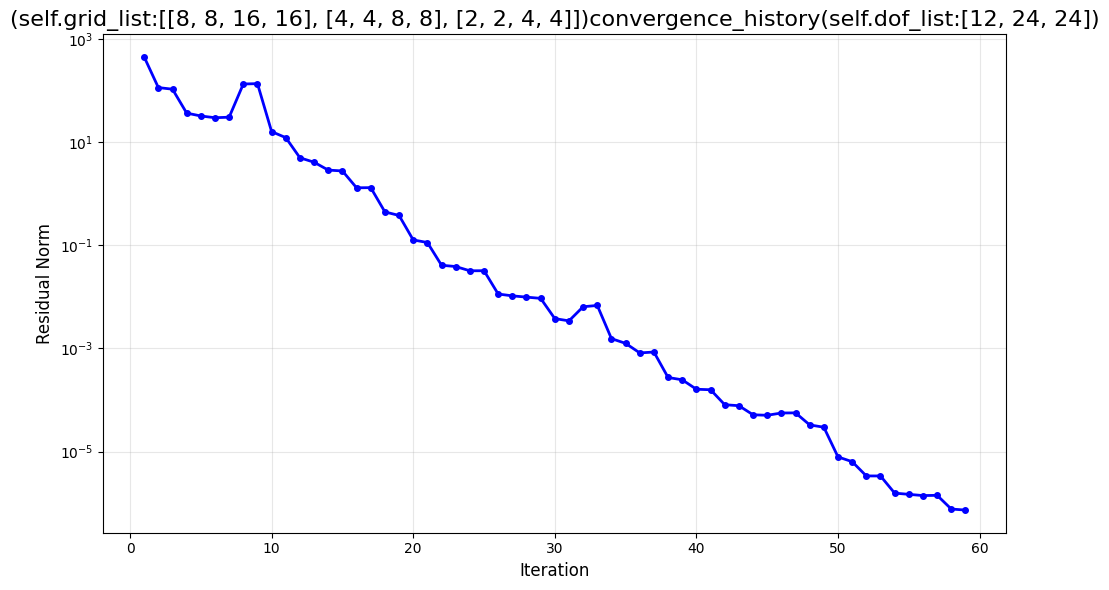

In [9]:
mg.num_levels = 2
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 7.3101e-10-4.5156e-10j,  3.1556e-09-7.8315e-10j,
         5.4111e-10-2.5411e-10j,  2.3680e-09-2.1675e-09j,
         2.1586e-10-1.0624e-09j,  5.5956e-10-1.3576e-09j,
        -8.0743e-10-5.2380e-10j, -5.8805e-10-1.1017e-10j,
         4.5046e-11+8.0683e-10j,  1.1787e-09-6.5827e-10j,
         4.4472e-10+1.5540e-10j,  3.0184e-09-1.5173e-09j,
        -2.9874e-10-2.4467e-10j,  1.7013e-09-4.4601e-11j,
         8.2972e-10-5.5297e-10j,  2.0455e-09-1.9430e-10j,
         1.5919e-09-1.2012e-09j,  6.1106e-10-2.7100e-09j,
         2.3355e-09-2.2928e-09j, -6.5783e-10-1.3055e-09j,
         1.1323e-10-1.1885e-09j, -8.1839e-10+1.9718e-10j,
        -8.2502e-10-8.5011e-10j, -9.3529e-10+6.6821e-11j,
        -1.0868e-09+1.9000e-10j,  7.0341e-10+7.2365e-10j,
         2.7208e-09+3.6882e-10j,  8.2396e-10-5.9892e-10j,
         9.5466e-10-2.8391e-10j, -3.1175e-10+1.3929e-09j,
         4.9689e-10+1.1223e-11j, -9.5899e-10-5.8347e-10j,
        -3.4204e-10+3.4868e-11j,  2.4022e-09-6.1566e-10j,
        -8.267

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

1.1950715799677188e-07


In [13]:
mg.num_levels

2

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0296+0.0016j, 0.0268+0.0035j, 0.0228-0.0055j, 0.0195-0.0033j,
        0.0123-0.0108j, 0.0092-0.0096j, 0.0002-0.0096j, 0.0063-0.0156j,
        0.0016-0.0049j, 0.0088-0.0107j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([ 0.0046+0.0037j, -0.0003+0.0039j,  0.0021+0.0050j,  0.0003+0.0011j,
         0.0031+0.0045j,  0.0115+0.0014j,  0.0145+0.0001j,  0.0201+0.0038j,
         0.0225+0.0008j,  0.0235+0.0036j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0019-0.0043j,  0.0248-0.0044j, -0.0126+0.0054j,  0.0135-0.0077j,
        -0.0223-0.0049j,  0.0100+0.0100j,  0.0096+0.0108j,  0.0068+0.0246j,
         0.0207+0.0098j,  0.0125+0.0139j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0197-0.0094j, 0.0230-0.0060j, 0.0250-0.0081j, 0.0244-0.0070j,
     

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0080-0.0031j, -0.0078-0.0028j, -0.0083-0.0040j, -0.0087-0.0056j,
        -0.0101-0.0064j, -0.0111-0.0061j, -0.0115-0.0051j, -0.0102-0.0045j,
        -0.0089-0.0031j, -0.0083-0.0027j, -0.0087-0.0034j, -0.0099-0.0052j,
        -0.0116-0.0060j, -0.0127-0.0057j, -0.0127-0.0047j, -0.0106-0.0045j,
        -0.0091-0.0042j, -0.0081-0.0038j, -0.0087-0.0045j, -0.0109-0.0052j,
        -0.0127-0.0056j, -0.0135-0.0048j, -0.0119-0.0044j, -0.0113-0.0037j,
        -0.0095-0.0050j, -0.0080-0.0047j, -0.0092-0.0056j, -0.0105-0.0064j,
        -0.0119-0.0071j, -0.0119-0.0057j, -0.0108-0.0052j, -0.0105-0.0047j,
        -0.0080-0.0054j, -0.0070-0.0063j, -0.0081-0.0075j, -0.0099-0.0080j,
        -0.0113-0.0080j, -0.0118-0.0065j, -0.0103-0.0054j, -0.0094-0.0054j,
        -0.0064-0.0050j, -0.0060-0.0064j, -0.0071-0.0079j, -0.0091-0.0082j,
        -0.0104-0.0080j, -0.0103-0.0069j, -0.0093-0.0056j, -0.0083-0.0049j,
        -0.0060-0.0040j, -0.0063-0.0052j, -0.0068-0.0068j, -0.0085-0.0071j,
        -0.0

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(495.5740, device='cuda:0', dtype=torch.float64)
tensor([-0.9301+0.1655j,  1.0642-1.0187j,  0.1578+1.7385j,  0.5534-1.1811j,
        -0.0530+0.5550j, -0.6252-2.5803j, -0.7322+0.5883j, -0.0252+0.1804j,
        -0.1422-0.0628j,  0.1513+0.6382j, -0.6308-0.2544j,  0.5003-0.1291j,
         0.8846+0.3306j, -0.4361+1.0535j, -0.1540-0.7522j, -0.1224+0.5302j,
         1.7814-0.0420j,  0.8128-0.7382j, -0.0912+0.3307j, -0.5397+1.0378j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:495.5739925627657
Norm of r:700.4224887099971
Norm of x0:442.8708318604005
BICGSTAB-Iteration 0: Residual = 1.207991e+02, Time = 0.011960 s
BICGSTAB-Iteration 1: Residual = 3.949643e+01, Time = 0.011931 s
BICGSTAB-Iteration 2: Residual = 6.373624e+01, Time = 0.011933 s
BICGSTAB-Iteration 3: Residual = 1.318824e+01, Time = 0.012115 s
BICGSTAB-Iteration 4: Residual = 8.461982e+00, Time = 0.012558 s
BICGSTAB-Iteration 5: Residual = 6.393645e+00, Time = 0.011950 s
BICGSTAB-Iteration 6: Residual = 5.521805

BICGSTAB-Iteration 31: Residual = 1.021680e-01, Time = 0.012050 s
BICGSTAB-Iteration 32: Residual = 9.629723e-02, Time = 0.012153 s
BICGSTAB-Iteration 33: Residual = 8.952656e-02, Time = 0.012026 s
BICGSTAB-Iteration 34: Residual = 8.219194e-02, Time = 0.011969 s
BICGSTAB-Iteration 35: Residual = 8.208997e-02, Time = 0.011994 s
BICGSTAB-Iteration 36: Residual = 7.851887e-02, Time = 0.012062 s
BICGSTAB-Iteration 37: Residual = 1.055967e-01, Time = 0.012056 s
BICGSTAB-Iteration 38: Residual = 6.555640e-02, Time = 0.011966 s
BICGSTAB-Iteration 39: Residual = 6.644263e-02, Time = 0.012197 s
BICGSTAB-Iteration 40: Residual = 8.736269e-02, Time = 0.012187 s
BICGSTAB-Iteration 41: Residual = 1.054687e-01, Time = 0.012011 s
BICGSTAB-Iteration 42: Residual = 1.026779e-01, Time = 0.011996 s
BICGSTAB-Iteration 43: Residual = 9.682970e-02, Time = 0.012006 s
BICGSTAB-Iteration 44: Residual = 9.127095e-02, Time = 0.011959 s
BICGSTAB-Iteration 45: Residual = 9.202915e-02, Time = 0.012063 s
BICGSTAB-I

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:443.7193747128637
Norm of r:667.0894137743694
Norm of x0:443.6490785219461
BICGSTAB-Iteration 0: Residual = 1.437567e+02, Time = 0.011992 s
BICGSTAB-Iteration 1: Residual = 6.095761e+01, Time = 0.012043 s
BICGSTAB-Iteration 2: Residual = 6.590105e+01, Time = 0.011940 s
BICGSTAB-Iteration 3: Residual = 3.984279e+01, Time = 0.011959 s
BICGSTAB-Iteration 4: Residual = 2.485570e+01, Time = 0.012131 s
BICGSTAB-Iteration 5: Residual = 1.821586e+01, Time = 0.012259 s
BICGSTAB-Iteration 6: Residual = 1.743107e+01, Time = 0.012038 s
BICGSTAB-Iteration 7: Residual = 2.195824e+01, Time = 0.012382 s
BICGSTAB-Iteration 8: Residual = 1.258354e+01, Time = 0.012167 s
BICGSTAB-Iteration 9: Residual = 9.737644e+00, Time = 0.012054 s
BICGSTAB-Iteration 10: Residual = 2.180089e+01, Time = 0.011946 s
BICGSTAB-Iteration 11: Residual = 7.768428e+00, Time = 0.011984 s
BICGSTAB-Iteration 12: Residual = 4.819202e+00, Time = 0.011966 s
BICGSTAB-Iteration 13: Residual = 4.370855e+00, Time = 0.011958 s
B

BICGSTAB-Iteration 20: Residual = 2.674964e+00, Time = 0.012029 s
BICGSTAB-Iteration 21: Residual = 2.901616e+00, Time = 0.012478 s
BICGSTAB-Iteration 22: Residual = 2.933759e+00, Time = 0.012016 s
BICGSTAB-Iteration 23: Residual = 2.671565e+00, Time = 0.011984 s
BICGSTAB-Iteration 24: Residual = 3.164173e+00, Time = 0.011975 s
BICGSTAB-Iteration 25: Residual = 7.273095e+00, Time = 0.011969 s
BICGSTAB-Iteration 26: Residual = 9.631710e+00, Time = 0.011948 s
BICGSTAB-Iteration 27: Residual = 4.854623e+00, Time = 0.011972 s
BICGSTAB-Iteration 28: Residual = 4.759980e+00, Time = 0.012047 s
BICGSTAB-Iteration 29: Residual = 5.593185e+00, Time = 0.012144 s
BICGSTAB-Iteration 30: Residual = 3.187961e+00, Time = 0.011956 s
BICGSTAB-Iteration 31: Residual = 1.651173e+00, Time = 0.011941 s
BICGSTAB-Iteration 32: Residual = 1.731634e+00, Time = 0.011895 s
BICGSTAB-Iteration 33: Residual = 1.528408e+00, Time = 0.011983 s
BICGSTAB-Iteration 34: Residual = 1.370937e+00, Time = 0.012281 s
BICGSTAB-I

In [18]:
_null_vec.flatten()[:100]

tensor([ 0.0009-0.0014j,  0.0007-0.0008j,  0.0003-0.0008j,  0.0004-0.0003j,
         0.0007-0.0003j,  0.0005-0.0010j, -0.0002-0.0010j,  0.0006-0.0006j,
         0.0007-0.0002j,  0.0004-0.0004j,  0.0010-0.0004j,  0.0014-0.0005j,
         0.0013-0.0004j,  0.0012-0.0007j,  0.0011-0.0005j,  0.0013-0.0007j,
         0.0014-0.0007j,  0.0005-0.0004j,  0.0003-0.0007j,  0.0006-0.0005j,
         0.0005-0.0012j,  0.0007-0.0011j,  0.0007-0.0007j,  0.0008-0.0005j,
         0.0004-0.0006j,  0.0008-0.0005j,  0.0013-0.0005j,  0.0012-0.0009j,
         0.0015-0.0009j,  0.0013-0.0002j,  0.0013-0.0009j,  0.0013-0.0008j,
         0.0006-0.0009j,  0.0008-0.0008j,  0.0006-0.0007j,  0.0012-0.0004j,
         0.0008-0.0007j,  0.0007-0.0007j,  0.0009-0.0005j,  0.0005-0.0005j,
         0.0007-0.0004j,  0.0011-0.0006j,  0.0010-0.0002j,  0.0015-0.0006j,
         0.0010-0.0010j,  0.0013-0.0008j,  0.0011-0.0008j,  0.0008-0.0008j,
         0.0007-0.0009j,  0.0007-0.0008j,  0.0010-0.0007j,  0.0009-0.0006j,
         0.0